# GOES-16 In The Classroom Using Python

There are any number of ways to utilize the new GOES-16 (and GOES-17) in the classroom from Synoptic meteorology to radiation. This lecture will use Jupyter notebooks with Python to read, calculate, and visualize GOES-16 GOES Rebroadcast (GRB) feed data that is accessed from a THREDDS data server. The data from the GRB are radiance values for a particular channel (1-16), which need to be modified to plot the typical variables that are plotted and used by meteorologists.

## Importing Needed Libraries

There are a number of different libraries that are needed to read, calculate, and plot satellite data. The following is a list of the libraries used in this lecture.
- datetime (https://docs.python.org/3/library/datetime.html)
- cartopy (https://scitools.org.uk/cartopy/docs/latest/)
- matplotlib (https://matplotlib.org)
- metpy (https://unidata.github.io/MetPy/latest/index.html)
- netCDF4 (http://unidata.github.io/netcdf4-python/)
- numpy (https://docs.scipy.org/doc/numpy-1.14.0/reference/)
- siphon (https://unidata.github.io/siphon/latest/index.html)
- scipy (https://docs.scipy.org/doc/scipy/reference/)
- xarray (http://xarray.pydata.org/en/stable/)

In [1]:
import warnings
warnings.filterwarnings('ignore')

from datetime import datetime

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
from metpy.plots import ctables
from metpy.units import units
from netCDF4 import num2date
import numpy as np
from scipy.ndimage import gaussian_filter
from siphon.catalog import TDSCatalog
import xarray as xr

## GOES-16 Data - Access from Python
As seen in previous presentations, there are a number of different ways to access GOES-16 data. Here we will use the Siphon (https://unidata.github.io/siphon/latest/index.html) library to find the most recent file and obtain the URL for the OPeNDAP access method.

Recent GOES-16 Data available at: http://thredds-test.unidata.ucar.edu/thredds/catalog/satellite/goes16/catalog.html

**Note:** When using Siphon, switch from using ".html" to ".xml" - if you don't, Siphon will make the change for you and give you a warning message.

In [2]:
# Set channel number (1-16)
# Channels 1-6 (Visible)
# Channel 7 (daylight/nighttime band)
# Channels 8-10 (Water Vapor)
# Channels 11-16 (IR)

channel = 14
catalog_url = 'http://thredds-test.unidata.ucar.edu/thredds/catalog/satellite/'\
              'goes16/GRB16/ABI/CONUS/Channel{:02d}/current/'.format(channel)
current_goes16 = TDSCatalog(catalog_url+'catalog.xml')

latest_file = current_goes16.datasets[-1]
latest_file_url = latest_file.access_urls['OPENDAP']
print(latest_file_url)

http://thredds-test.unidata.ucar.edu/thredds/dodsC/satellite/goes16/GRB16/ABI/CONUS/Channel14/current/OR_ABI-L1b-RadC-M3C14_G16_s20181781327191_e20181781329564_c20181781330009.nc


### Remote data read
We will use the Xarray library to remotely read the data from the THREDDS server using the URL we found (and is printed above).

By using Xarray we will have access to a data handle that we can couple that with the metpy library to allow us easier access to the appropriate map projection information needed for plotting.

Note: Xarray is "lazy" meaning that it is not going to actually download the data until it need to access it. This is great in the case of needing to subset data prior to using it in a calculation because it will only bring back the data that you need and not the whole dataset.

In [3]:
# Access the remote file on the THREDDS server
ds = xr.open_dataset(latest_file_url)
ds

<xarray.Dataset>
Dimensions:                                 (band: 1, num_star_looks: 24, number_of_image_bounds: 2, number_of_time_bounds: 2, x: 2500, y: 1500)
Coordinates:
  * y                                       (y) float32 0.128212 0.128156 ...
  * x                                       (x) float32 -0.101332 -0.101276 ...
    t                                       datetime64[ns] ...
    y_image                                 float32 ...
    x_image                                 float32 ...
    band_id                                 (band) uint8 ...
    band_wavelength                         (band) float32 ...
    t_star_look                             (num_star_looks) datetime64[ns] ...
    band_wavelength_star_look               (num_star_looks) float32 ...
Dimensions without coordinates: band, num_star_looks, number_of_image_bounds, number_of_time_bounds
Data variables:
    time_bounds                             (number_of_time_bounds) float64 ...
    goes_imager_pro

In [4]:
# Get projection information from the file
rad = ds.metpy.parse_cf('Rad')
dataproj = rad.metpy.cartopy_crs

# Grab coordinate data
x = rad.x
y = rad.y

# Grab time from file and convert to a nice format
vtime = datetime.strptime(ds.time_coverage_end, '%Y-%m-%dT%H:%M:%S.%fZ')

In [5]:
# Isolate the radiance values from the dataset
# Note: the data isn't downloaded here, just metadata
ir_rad = ds.Rad
print(ir_rad)

<xarray.DataArray 'Rad' (y: 1500, x: 2500)>
[3750000 values with dtype=float32]
Coordinates:
  * y        (y) float32 0.128212 0.128156 0.12810001 0.12804401 0.12798801 ...
  * x        (x) float32 -0.101332 -0.101276 -0.101220004 -0.101164 ...
    t        datetime64[ns] ...
    y_image  float32 ...
    x_image  float32 ...
Attributes:
    long_name:              ABI L1b Radiances
    standard_name:          toa_outgoing_radiance_per_unit_wavenumber
    sensor_band_bit_depth:  12
    valid_range:            [   0 4094]
    units:                  mW m-2 sr-1 (cm-1)-1
    resolution:             y: 0.000056 rad x: 0.000056 rad
    cell_methods:           t: point area: point
    ancillary_variables:    DQF
    _ChunkSizes:            [226 226]


## Radiance to Brightness Temperature

The GRB feed has the top of the atmosphere radiance values with the units given above. The data that we are accessing is from Channel 14, which happens to be the 11 micron channel, which is an infrared channel. Typically we would want to plot the Brightness Temperature (BT). This can be accomplished by using our knowledge of radiation through Plank's Function.

### Radiance based on Plank function

\begin{equation}
L_\lambda = \frac{fk_1}{e^{fk2/T}-1}
\end{equation}

### Inverse Plank Function to get Brightness Temperature


\begin{equation}
T = \frac{fk_2}{ln \bigg[\frac{fk_1}{L_\lambda} + 1\bigg]}
\end{equation}


\begin{equation}
BT = T*bc_2 + bc_1
\end{equation}

Equation 3-5 from page 22 (NOAA 2018)

where

$fk_1$ is the 1st Plank Constant

$fk_2$ is the 2nd Plank Constant

$bc_1$ is a spectral bandpass offest for BT

$bc_2$ is a spectral bandpass scale factor for BT

Source: NOAA 2018, https://www.star.nesdis.noaa.gov/goesr/docs/ATBD/Imagery.pdf

The constants that are needed to complete the calculation are different depending on the exact channel used and are included im the the file as variables.

In [6]:
print(ds.planck_bc1)
print(ds.planck_bc2)
print(ds.planck_fk1)
print(ds.planck_fk2)

<xarray.DataArray 'planck_bc1' ()>
array(0.22516)
Coordinates:
    t        datetime64[ns] ...
    y_image  float32 ...
    x_image  float32 ...
Attributes:
    long_name:  spectral bandpass correction offset for brightness temperatur...
    units:      K
<xarray.DataArray 'planck_bc2' ()>
array(0.9992)
Coordinates:
    t        datetime64[ns] ...
    y_image  float32 ...
    x_image  float32 ...
Attributes:
    long_name:  spectral bandpass correction scale factor for brightness temp...
    units:      1
<xarray.DataArray 'planck_fk1' ()>
array(8510.219727)
Coordinates:
    t        datetime64[ns] ...
    y_image  float32 ...
    x_image  float32 ...
Attributes:
    long_name:  wavenumber-dependent coefficient (2 h c2/ nu3) used in the AB...
    units:      W m-1
<xarray.DataArray 'planck_fk2' ()>
array(1286.27, dtype=float32)
Coordinates:
    t        datetime64[ns] ...
    y_image  float32 ...
    x_image  float32 ...
Attributes:
    long_name:  wavenumber-dependent coefficient (h c

In [7]:
# Save values needed for conversion to variables
fk1 = ds.planck_fk1
fk2 = ds.planck_fk2
bc1 = ds.planck_bc1
bc2 = ds.planck_bc2

# Calculate the brightness temperature from inverse Plank
T = fk2 / (np.log((fk1 / ir_rad) + 1))

# Add scale and offest correction to obtain final BT for particular channel
ir_BT = bc2*T + bc1

### Create a plot of our Brightness Temperature data

The following code uses a combination of matplotlib, cartopy, and metpy to plot our BT data on a map in the correct projection wth an appropriate colormap.

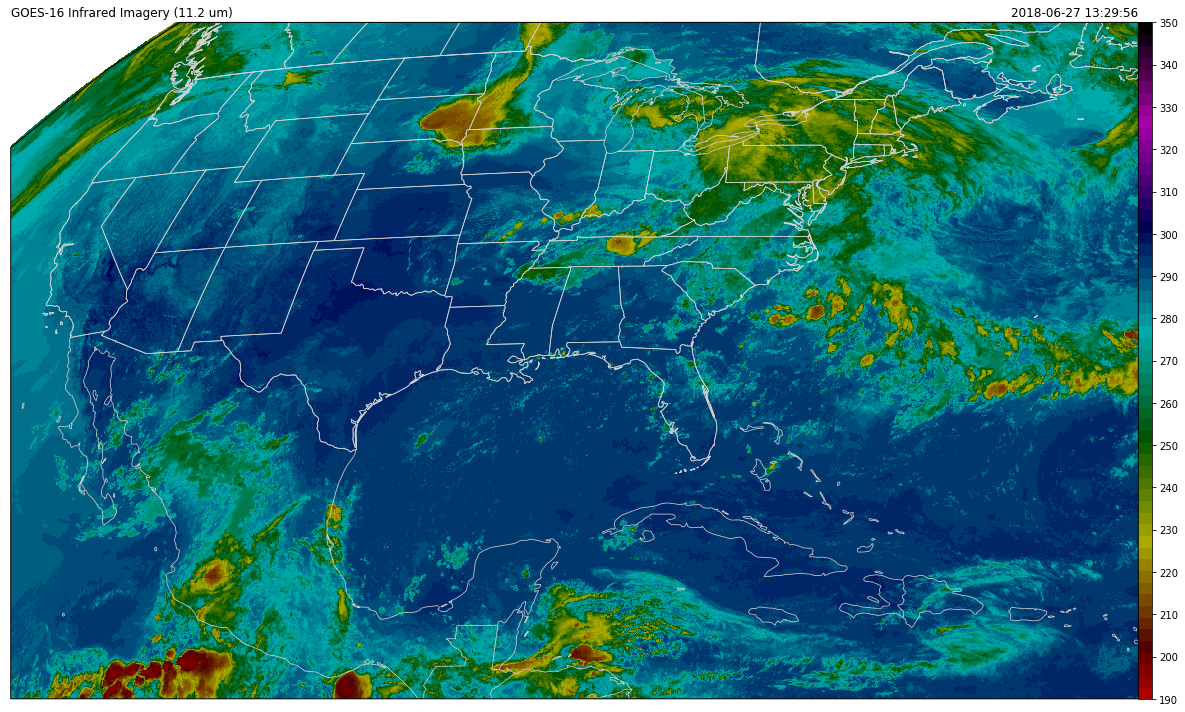

In [8]:
# Start figure and set up projected axis for plotting
fig = plt.figure(1, figsize=(20,10))
ax = plt.subplot(111, projection=dataproj)

# Use cartopy feature module to add coastlines, country borders, and state lines
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), edgecolor='lightgrey', linewidths=0.75)
ax.add_feature(cfeature.BORDERS.with_scale('50m'), edgecolor='lightgrey', linewidths=0.75)
ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='lightgrey', linewidths=0.75)

# Get a colormap from metpy with a range of brightness values
ir_norm, ir_cmap = ctables.registry.get_with_range('ir_drgb_r', 190, 350)

# Plot the BT data with a colorbar describing the colors by temperature
img = ax.imshow(ir_BT, extent=(x.min(), x.max(), y.min(), y.max()), origin='upper', cmap=ir_cmap, norm=ir_norm)
plt.colorbar(img, orientation='vertical', pad=0, aspect=50, ticks=range(190,351,10))

# Add some titles
plt.title('GOES-16 Infrared Imagery ({:0.1f} um)'.format(ds.band_wavelength.data[0]), loc='left')
plt.title('{0:%Y-%m-%d %H:%M:%S}'.format(vtime), loc='right')

# Show the plot
plt.tight_layout()
plt.show()
# plt.savefig('IR_satellite.png')

## Radiance to Emitted Energy

Now lets use a channel that is responsive to the amount of water vapor (Channel 9). Here we are going to use the same process that we used for the infrared channel above to get to the Brightness Temperature

In [9]:
channel = 9
catalog_url = 'http://thredds-test.unidata.ucar.edu/thredds/catalog/satellite/'\
              'goes16/GRB16/ABI/CONUS/Channel{:02d}/current/'.format(channel)
current_goes16 = TDSCatalog(catalog_url+'catalog.xml')

latest_file = current_goes16.datasets[-1]
latest_file_url = latest_file.access_urls['OPENDAP']
print(latest_file_url)

ds = xr.open_dataset(latest_file_url)
rad = ds.metpy.parse_cf('Rad')

dataproj = rad.metpy.cartopy_crs

x = rad.x
y = rad.y

vtime = datetime.strptime(ds.time_coverage_end, '%Y-%m-%dT%H:%M:%S.%fZ')

wv_rad = ds.Rad

fk1 = ds.planck_fk1
fk2 = ds.planck_fk2
bc1 = ds.planck_bc1
bc2 = ds.planck_bc2

wv_BT = (fk2 / (np.log((fk1/wv_rad)+1)) - bc1)/bc2

http://thredds-test.unidata.ucar.edu/thredds/dodsC/satellite/goes16/GRB16/ABI/CONUS/Channel09/current/OR_ABI-L1b-RadC-M3C09_G16_s20181781327191_e20181781329570_c20181781330008.nc


In [10]:
print(ds.band_wavelength.data[0], ds.band_wavelength.units)

6.95 um


### Stefan-Boltzman Law

Outgoing longwave radiation is absorbed by water vapor in the wavelength range of 5.2-7.2 microns, which means that less energy escapes to space. We can use the Stefan-Boltzman law to confirm that is the case.

\begin{equation}
E = \sigma T^4
\end{equation}

where $\sigma$ is the Stefan-Boltzman constant $5.67e^{-8}$

![Electromagnetic Spectrum](https://cosmoscon.files.wordpress.com/2011/12/atmospheric_transmission.png)

Source: https://cosmoscon.files.wordpress.com/2011/12/atmospheric_transmission.png

In [11]:
# Set Stefan-Boltzman Constant
sb_constant = 5.67e-8

# Calculate Emitted Energy based on Stefan-Boltzman relationship
E = sb_constant*wv_BT**4

print(E.min().data)

75.4816032398268


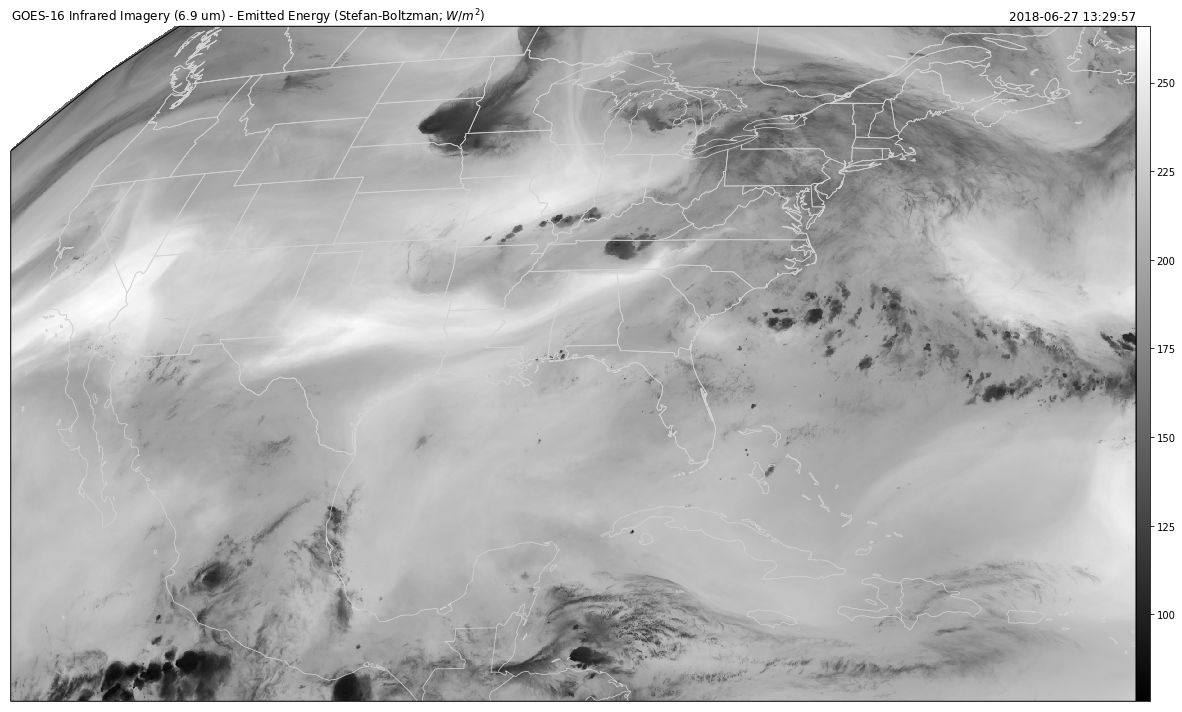

In [12]:
# Start figure and set up projected axis for plotting
fig = plt.figure(1, figsize=(20,10))
ax = plt.subplot(111, projection=dataproj)

# Add geopolitical lines
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), edgecolor='lightgrey', linewidths=0.75)
ax.add_feature(cfeature.BORDERS.with_scale('50m'), edgecolor='lightgrey', linewidths=0.75)
ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='lightgrey', linewidths=0.75)

# Plot emitted energy based on Stefan-Boltzman
img = ax.imshow(E, extent=(x.min(), x.max(), y.min(), y.max()), origin='upper', cmap=plt.cm.gray)
plt.colorbar(img, orientation='vertical', pad=0, aspect=50)

# Plot titles
plt.title('GOES-16 Infrared Imagery ({:0.1f} um) - Emitted Energy (Stefan-Boltzman; $W/m^2$)'.format(ds.band_wavelength.data[0]),
          loc='left')
plt.title('{0:%Y-%m-%d %H:%M:%S}'.format(vtime), loc='right')

plt.tight_layout()
plt.show()
# plt.savefig('WV_Stefan_Boltzman.png')

Notice that the dark areas on this plot are where there is a lot of water vapor in the atmospheric column, meaning the outgoing longwave radiation is being absorbed at this particular wavelength.

We can compare that to how we would normally view a water vapor image from a Geostationary satellite.

#### Plot regular Water Vapor Imagery

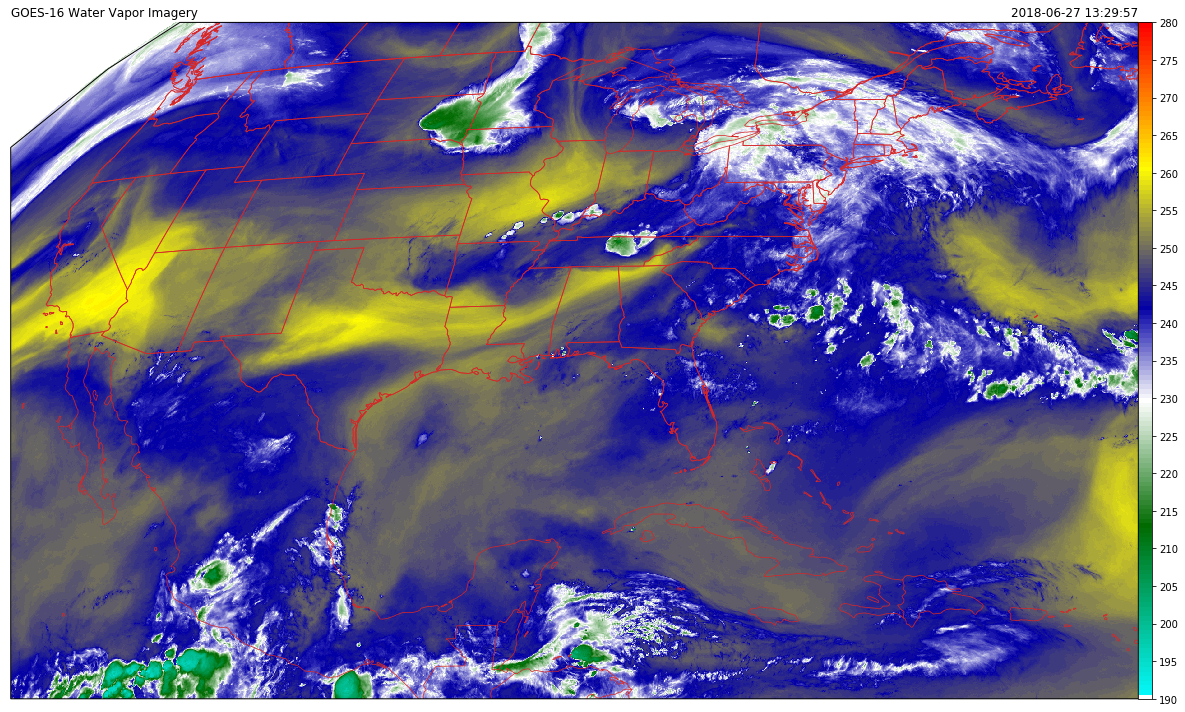

In [13]:
# Start figure and set up projected axis for plotting
fig = plt.figure(1, figsize=(20,10))
ax = plt.subplot(111, projection=dataproj)

# Add geopolitical lines
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), edgecolor='tab:red', linewidths=0.75)
ax.add_feature(cfeature.BORDERS.with_scale('50m'), edgecolor='tab:red', linewidths=0.75)
ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='tab:red', linewidths=0.75)

# WV Colormap from MetPy
wv_norm, wv_cmap = ctables.registry.get_with_range('WVCIMSS_r', 190, 280)

# Plot BT WV using the colormap
img = ax.imshow(wv_BT, extent=(x.min(), x.max(), y.min(), y.max()), origin='upper', cmap=wv_cmap, norm=wv_norm)
plt.colorbar(img, orientation='vertical', pad=0, aspect=50, ticks=range(180,290,5))

# Plot titles
plt.title('GOES-16 Water Vapor Imagery', loc='left')
plt.title('{0:%Y-%m-%d %H:%M:%S}'.format(vtime), loc='right')

plt.tight_layout()
plt.show()
# plt.savefig('WV_satellite.png')

## Overlay Isentropic and Satellite Imagery

Another great way to use satellite data is to use it in combination with another data source, such as a model analysis. Here we will use the BEST GFS to plot visible satellite data imagery with an isentropic surface. We'll need to use MetPy to calalculate atmospheric values on an isentropic surface (e.g., 300 K), then an overlay will be relatively easy when we use Cartopy to do some transofmraiton from lat/lon coordinates to the Geostationary projection.

### Visible Satellite Imagery
We'll continue to use the same source for the Visible statllite imagery (Channel 1), but here we won't need to convert to Brightness Temperature, we'll convert from radiance to reflectance factor (i.e., Albedo) and apply a gamma correction. This will take just a little longer than the IR data due to the finer spatial resolution of the visible data.

In [14]:
channel = 1
catalog_url = 'http://thredds-test.unidata.ucar.edu/thredds/catalog/satellite/'\
              'goes16/GRB16/ABI/CONUS/Channel{:02d}/current/'.format(channel)
current_goes16 = TDSCatalog(catalog_url+'catalog.xml')

latest_file = current_goes16.datasets[-1]
latest_file_url = latest_file.access_urls['OPENDAP']
print(latest_file_url)

ds = xr.open_dataset(latest_file_url)

# Get projection from satellite data
rad = ds.metpy.parse_cf('Rad')
dataproj = rad.metpy.cartopy_crs

# Grab coordinate data
x = rad.x
y = rad.y

# Grab time from file and convert to a nice format
vtime = datetime.strptime(ds.time_coverage_end, '%Y-%m-%dT%H:%M:%S.%fZ')

# Get Visible data, convert to reflectance factor and apply gamma correction
vis = np.sqrt(ds.Rad*ds.kappa0)

http://thredds-test.unidata.ucar.edu/thredds/dodsC/satellite/goes16/GRB16/ABI/CONUS/Channel01/current/OR_ABI-L1b-RadC-M3C01_G16_s20181781327191_e20181781329564_c20181781330011.nc


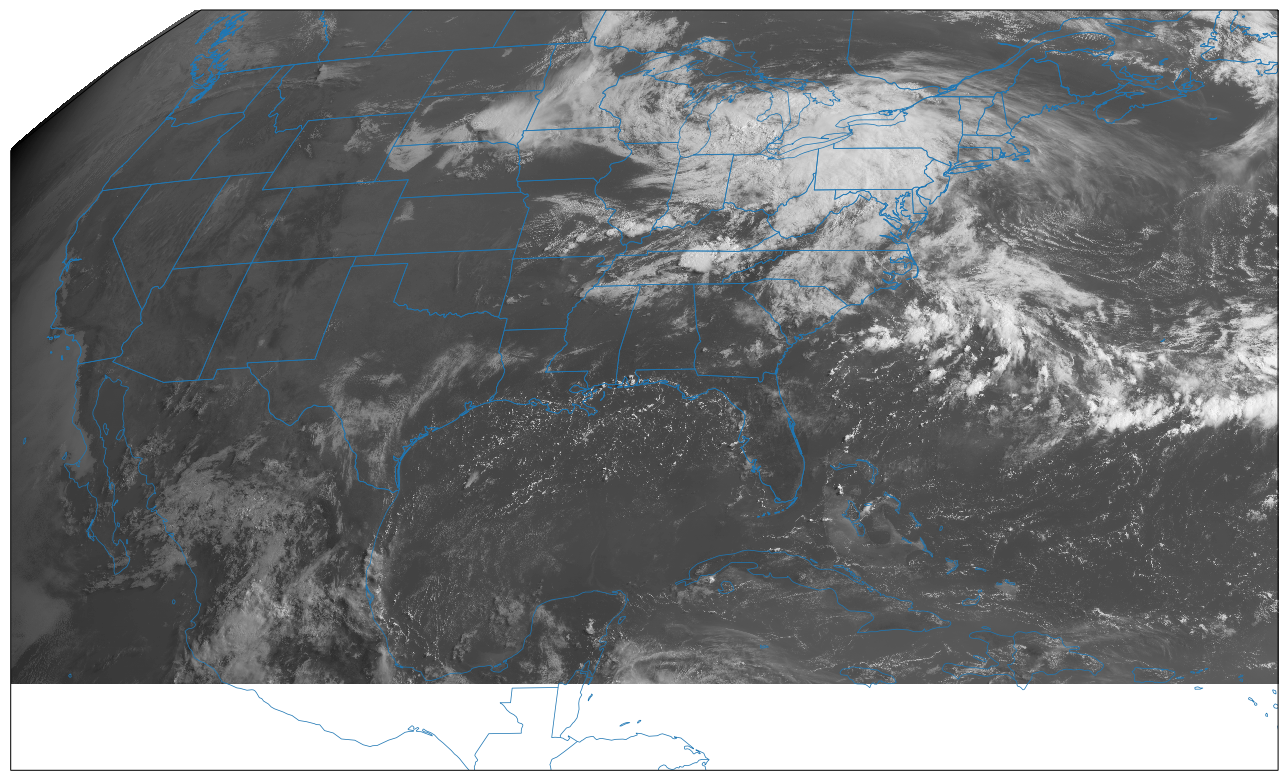

In [15]:
# Start figure and set up projection on axes for plotting
fig = plt.figure(1, figsize=(18,12))
ax = plt.subplot(111, projection=dataproj)

# Plot geopolitical lines
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), edgecolor='tab:blue', linewidths=0.75)
ax.add_feature(cfeature.BORDERS.with_scale('50m'), edgecolor='tab:blue', linewidths=0.75)
ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='tab:blue', linewidths=0.75)

# Plot gamma correction visible reflectance values
ax.imshow(vis, extent=(x.min(), x.max(), y.min(), y.max()), origin='upper', cmap=plt.cm.Greys_r)

plt.tight_layout()
plt.show()

### GFS Data

The GFS provides a nice global dataset that can be used to obtain the most recent (nearset 6 hour analysis) to overlay on top of satellite imagery. We can use the same functionality from Siphon and Xarray to read the remote dataset.

In [16]:
catalog_url = 'https://thredds.ucar.edu/thredds/catalog/grib/NCEP/GFS/Global_0p5deg_ana/latest.xml'
latest_gfs = TDSCatalog(catalog_url).datasets[0].access_urls['OPENDAP']

ds = xr.open_dataset(latest_gfs)
ds

<xarray.Dataset>
Dimensions:                                                          (altitude_above_msl: 3, height_above_ground: 2, isobaric: 31, isobaric1: 1, isobaric2: 21, isobaric3: 26, isobaric4: 17, isobaric5: 25, lat: 361, lon: 720, potential_vorticity_surface: 2, pressure_difference_layer: 1, pressure_difference_layer1: 1, pressure_difference_layer1_bounds_1: 2, pressure_difference_layer_bounds_1: 2, sigma: 1, sigma_layer: 4, sigma_layer_bounds_1: 2, time: 1)
Coordinates:
  * lat                                                              (lat) float32 90.0 ...
  * lon                                                              (lon) float32 0.0 ...
    reftime                                                          datetime64[ns] ...
  * time                                                             (time) datetime64[ns] 2018-06-27T06:00:00 ...
  * isobaric                                                         (isobaric) float32 100.0 ...
  * sigma                    

Extracting the necessary variables is completed below. Since we do not desire to have the full global data and only need the values that surround the CONUS, we'll set up a slice variable so that we only download the data that we desire.

In [17]:
# Get the coordinate data
lats = ds.lat.data
lons = ds.lon.data

# Set subset slice for the geographic extent of data to limit download
lon_slice = slice(400,601)
lat_slice = slice(10,160)

# Subset lat/lon values
slons = lons[lon_slice]
slats = lats[lat_slice]
print(360-slons)
print(slats)

# Get the values needed to compute isentropic coordinates and subset on read
pres = ds[ds.Temperature_isobaric.dims[1]].data[:] * units('Pa')
tmpk = gaussian_filter(ds['Temperature_isobaric'].data[0,:,lat_slice,lon_slice], sigma=1.0) * units.K
uwnd = gaussian_filter(ds['u-component_of_wind_isobaric'].data[0,:,lat_slice,lon_slice], sigma=1.0) * units('m/s')
vwnd = gaussian_filter(ds['v-component_of_wind_isobaric'].data[0,:,lat_slice,lon_slice], sigma=1.0) * units('m/s')

# Calculate the Potential Temperature from TMPK and PRES using MetPy
thta = mpcalc.potential_temperature(pres[:, None, None], tmpk)

# Get time value and put into a better format
vtime = datetime.strptime(str(ds.Geopotential_height_isobaric.time.data[0].astype('datetime64[ms]')),
                          '%Y-%m-%dT%H:%M:%S.%f')

[160.  159.5 159.  158.5 158.  157.5 157.  156.5 156.  155.5 155.  154.5
 154.  153.5 153.  152.5 152.  151.5 151.  150.5 150.  149.5 149.  148.5
 148.  147.5 147.  146.5 146.  145.5 145.  144.5 144.  143.5 143.  142.5
 142.  141.5 141.  140.5 140.  139.5 139.  138.5 138.  137.5 137.  136.5
 136.  135.5 135.  134.5 134.  133.5 133.  132.5 132.  131.5 131.  130.5
 130.  129.5 129.  128.5 128.  127.5 127.  126.5 126.  125.5 125.  124.5
 124.  123.5 123.  122.5 122.  121.5 121.  120.5 120.  119.5 119.  118.5
 118.  117.5 117.  116.5 116.  115.5 115.  114.5 114.  113.5 113.  112.5
 112.  111.5 111.  110.5 110.  109.5 109.  108.5 108.  107.5 107.  106.5
 106.  105.5 105.  104.5 104.  103.5 103.  102.5 102.  101.5 101.  100.5
 100.   99.5  99.   98.5  98.   97.5  97.   96.5  96.   95.5  95.   94.5
  94.   93.5  93.   92.5  92.   91.5  91.   90.5  90.   89.5  89.   88.5
  88.   87.5  87.   86.5  86.   85.5  85.   84.5  84.   83.5  83.   82.5
  82.   81.5  81.   80.5  80.   79.5  79.   78.5  7

In [18]:
# Set levels to compute isentropic surfaces
isentlevs = list(range(280,331,2)) * units.K
print(isentlevs)

# Use MetPy functionality to computer isentropic levels
isent_anal = mpcalc.isentropic_interpolation(isentlevs,
                                             pres,
                                             tmpk,
                                             uwnd,
                                             vwnd)

isentprs, isentu, isentv = isent_anal

# Convert U and V to units of knots
isentu.ito('kt')
isentv.ito('kt')

[280 282 284 286 288 290 292 294 296 298 300 302 304 306 308 310 312 314 316 318 320 322 324 326 328 330] kelvin


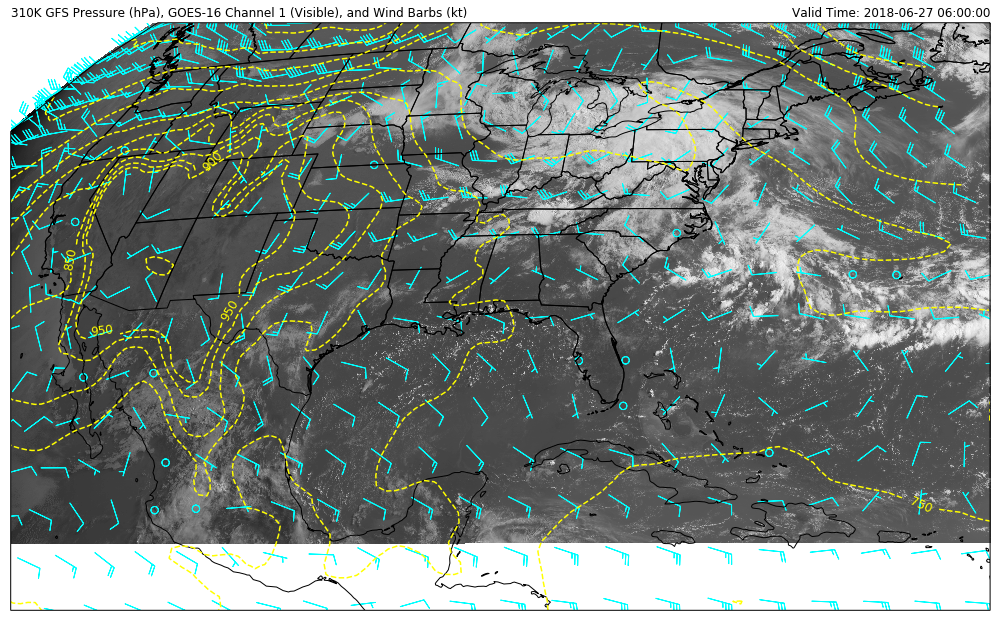

In [19]:
# Set which isentropic level to plot from the above list
ilev = list(isentlevs.m).index(310)

# Set GFS data coordinate reference system, 
# need to know this for transformation purposes
datacrs = ccrs.PlateCarree()

# Start figure and set up axes for plotting on the Geostationary projection
fig = plt.figure(1, figsize=(14,12))
ax = plt.subplot(111, projection=dataproj)
ax.set_extent([x.min(), x.max(), y.min(), y.max()], dataproj)

# Add geopolitical lines for reference
ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.add_feature(cfeature.STATES.with_scale('50m'))

# Plot the visible satellite imagery
ax.imshow(vis, extent=(x.min(), x.max(), y.min(), y.max()), origin='upper', cmap=plt.cm.Greys_r)

# Plot the pressure of the isentropic surface
clevs_pres = np.arange(0, 1100, 50)
cs1 = ax.contour(slons, slats, isentprs[ilev], clevs_pres, colors='yellow',
                 linestyles='dashed', transform=datacrs)
plt.clabel(cs1, fmt='%d', fontsize='large')

# Plot the every fifth wind barb in knots on the isentropic surface
ax.barbs(slons[::5], slats[::5], isentu[ilev,::5,::5].m, isentv[ilev,::5,::5].m, pivot='middle',
         color='cyan', transform=datacrs)

# Plot some titles
plt.title('{}K GFS Pressure (hPa), GOES-16 Channel 1 (Visible), and Wind Barbs (kt)'.format(isentlevs[ilev].m), loc='left')
plt.title('Valid Time: {}'.format(vtime), loc='right')

plt.tight_layout()
plt.show()
# plt.savefig('overlay_isent_visible_satellite.png')

## Create your own Overlay Map with Satellite Imagery

In the cell below, create your own map that uses Satellite Imagery (any channel) with some GFS data (e.g., 300-hPa wind speed). Use code from various cells above to help - don't feel like you need to start over at the beginning.